# Exploring the types given by the first doc

In [186]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({'font.size': 14})
import scipy.stats as stats

# name of the bundesland
bundesland = 'baden-württemberg'
bundeslandCapitalized = 'Baden-Württemberg'


In [187]:
# load the xes event log into a pandas dataframe
dataframe = pm4py.read_xes('../all-data-xes/' + bundesland + '-all-preprocessed.xes')

parsing log, completed traces ::   0%|          | 0/59458 [00:00<?, ?it/s]

In [188]:
#dataframe

In [189]:
# get all the different VTyp values 
vtyps = dataframe['case:VTypL'].unique()
print("This many different VTyp values: ", len(vtyps))
print("The different VTyp values: ", vtyps)

This many different VTyp values:  10
The different VTyp values:  ['Antrag' 'Gesetzgebung' 'Anfrage' 'Bericht' 'Sonstiges'
 'Beschlussempfehlung' 'Gesetz' 'Wahl' 'Debatte' nan]


In [190]:
# get all the different case:DokTypLFirstDoc values
firstDocTypes = dataframe['case:DokTypLFirstDoc'].unique()
print("this many different firstDocTypes: ", len(firstDocTypes))
#firstDocTypes

this many different firstDocTypes:  93


In [191]:
# Replace NaN values in 'case:VTypL' with 'no VTypL'
dataframe['case:VTypL'].fillna('no VTypL', inplace=True)

grouped_by_vtyp = dataframe.groupby('case:VTypL')['case:concept:name'].nunique()
print("total cases:", dataframe['case:concept:name'].nunique())
print(grouped_by_vtyp)

total_events_per_group = dataframe.groupby('case:VTypL').size()
print("\nTotal events per group:")
print(total_events_per_group)

total cases: 59458
case:VTypL
Anfrage                21381
Antrag                 25161
Bericht                 3027
Beschlussempfehlung     1758
Debatte                 1218
Gesetz                  3420
Gesetzgebung            1132
Sonstiges               1504
Wahl                     855
no VTypL                   2
Name: case:concept:name, dtype: int64

Total events per group:
case:VTypL
Anfrage                24424
Antrag                 66609
Bericht                 8824
Beschlussempfehlung     3748
Debatte                 1239
Gesetz                 11486
Gesetzgebung            6838
Sonstiges               1929
Wahl                     881
no VTypL                   3
dtype: int64


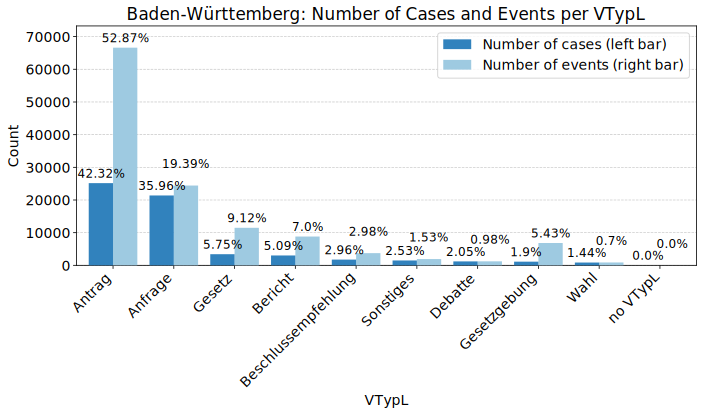

In [192]:
import textwrap
import matplotlib.pyplot as plt

# Sort by the number of unique cases
grouped_by_vtyp_sorted = grouped_by_vtyp.sort_values(ascending=False)
total_events_per_group_sorted = total_events_per_group[grouped_by_vtyp_sorted.index]

# Ensure "no VTypL" is the last element
if 'no VTypL' in grouped_by_vtyp_sorted.index:
    grouped_by_vtyp_sorted_no_vtypl = grouped_by_vtyp_sorted.pop('no VTypL')
    grouped_by_vtyp_sorted = pd.concat([grouped_by_vtyp_sorted, pd.Series(grouped_by_vtyp_sorted_no_vtypl, index=['no VTypL'])])
    
    total_events_per_group_sorted_no_vtypl = total_events_per_group_sorted.pop('no VTypL')
    total_events_per_group_sorted = pd.concat([total_events_per_group_sorted, pd.Series(total_events_per_group_sorted_no_vtypl, index=['no VTypL'])])

# Calculate the percentages
percentages_cases = (grouped_by_vtyp_sorted / grouped_by_vtyp_sorted.sum() * 100).round(2)
percentages_events = (total_events_per_group_sorted / total_events_per_group_sorted.sum() * 100).round(2)

# Plot the number of unique cases and total events per VTyp in one plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the total number of events per VTyp
total_events_per_group_sorted.plot(kind='bar', ax=ax, color='#9ecae1', position=0, width=0.4, label='Number of events (right bar)', zorder=3)

# Plot the number of unique cases per VTyp
grouped_by_vtyp_sorted.plot(kind='bar', ax=ax, color='#3182bd', position=1, width=0.4, label='Number of cases (left bar)', zorder=3)

# Annotate the bars with the percentages
for i in range(len(grouped_by_vtyp_sorted)):
    # Calculate the difference between the two values
    diff = abs(grouped_by_vtyp_sorted[i] - total_events_per_group_sorted[i])
    
    # Set different offsets based on the difference
    if diff < 4000:  # Adjust this threshold as needed
        offset_cases = 3
        offset_events = 15
    else:
        offset_cases = 3
        offset_events = 3
    
    ax.annotate(f'{percentages_cases[i]}%', 
                xy=(i - 0.2, grouped_by_vtyp_sorted[i]), 
                xytext=(0, offset_cases), 
                textcoords='offset points', 
                ha='center', va='bottom', fontsize=12, zorder=4)
    ax.annotate(f'{percentages_events[i]}%', 
                xy=(i + 0.2, total_events_per_group_sorted[i]), 
                xytext=(0, offset_events), 
                textcoords='offset points', 
                ha='center', va='bottom', fontsize=12, zorder=4)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7, zorder=1)

# Get handles and labels
handles, labels = ax.get_legend_handles_labels()

# Change the order of the elements in the legend
ax.legend(handles=[handles[1], handles[0]], labels=[labels[1], labels[0]])

ax.set_xlabel('VTypL')
ax.set_ylabel('Count')

# Wrap the x-axis labels only if there is a white space
wrapped_labels = [textwrap.fill(label, width=20, break_long_words=False) for label in grouped_by_vtyp_sorted.index]
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right')

# Adjust the axis limits to add more space
ax.set_ylim(0, max(total_events_per_group_sorted.max(), grouped_by_vtyp_sorted.max()) * 1.1)
ax.set_xlim(-0.6, len(grouped_by_vtyp_sorted) - 0.4)

plt.title(f'{bundeslandCapitalized}: Number of Cases and Events per VTypL')

plt.tight_layout()  # Automatically adjust layout to fit labels
plt.savefig(f'./plots/{bundesland}_cases_events_per_vtyp.png', format='png', dpi=300, bbox_inches="tight")
plt.savefig(f'./plots/{bundesland}_cases_events_per_vtyp.svg', format='svg', bbox_inches="tight")
plt.show()

In [193]:
from IPython.display import display, HTML

# Group by 'case:VTypL' and 'case:DokTypLFirstDoc' and sort each group by the count
grouped_by_vtyp_and_firstdoc = dataframe.groupby(['case:VTypL', 'case:DokTypLFirstDoc'])['case:concept:name'].nunique().reset_index(name='count')
sorted_per_group = grouped_by_vtyp_and_firstdoc.groupby('case:VTypL').apply(lambda x: x.sort_values('count', ascending=False)).reset_index(drop=True)

for vtyp in vtyps:
    if pd.isna(vtyp):
        continue
    group_data = sorted_per_group[sorted_per_group['case:VTypL'] == vtyp]
    this_group_total_count = group_data['count'].sum()
    sorted_per_group.loc[sorted_per_group['case:VTypL'] == vtyp, 'percentage'] = ((group_data['count'] / this_group_total_count) * 100).round(2)

# Display the sorted data in a scrollable HTML format
display(HTML("<style>.output_scroll { max-height: 300px; overflow-y: scroll; }</style>"))
sorted_per_group_html = sorted_per_group.to_html()
display(HTML(f'<div class="output_scroll">{sorted_per_group_html}</div>'))

# Export the sorted HTML to a file with ASCII encoding
#with open('./outputs/' + bundesland + '_sorted_per_group.html', 'w', encoding='ascii', errors='replace') as file:
#    file.write(sorted_per_group_html)

# Export the sorted data to a CSV file with a modified header
for vtyp in vtyps:
    if pd.isna(vtyp):
        continue
    group_data = sorted_per_group[sorted_per_group['case:VTypL'] == vtyp]
    group_data.to_csv(f'./outputs/{bundesland}_{vtyp}.csv', index=False, header=['VTypL', 'First Document Type', 'Count', 'Percentage'], encoding='utf-8', errors='replace', sep=';')


,case:VTypL,case:DokTypLFirstDoc,count,percentage
0,Anfrage,Kleine Anfrage und Antwort,18126,84.78
1,Anfrage,"['Mündliche Anfragen (Sammeldrucksache)', 'Mündliche Anfrage']",1574,7.36
2,Anfrage,Mündliche Anfrage,524,2.45
3,Anfrage,Große Anfrage und Antwort,473,2.21
4,Anfrage,Große Anfrage,227,1.06
5,Anfrage,Regierungsbefragung,214,1.00
6,Anfrage,Kleine Anfrage,95,0.44
7,Anfrage,"['Aktuelle Debatte', 'Regierungsbefragung']",62,0.29
8,Anfrage,"['Vorschlag', 'Regierungsbefragung']",38,0.18
9,Anfrage,Mündliche Anfragen (Sammeldrucksache),20,0.09


In [194]:
from IPython.display import display, HTML

# Group by 'case:VTypL' and 'case:DokTypLFirstDoc' and sort each group by the count
grouped_by_vtyp_and_firstdoc = dataframe.groupby(['case:VTypL', 'case:DokTypLFirstDoc'])['case:concept:name'].nunique().reset_index(name='count')
sorted_per_group = grouped_by_vtyp_and_firstdoc.groupby('case:VTypL').apply(lambda x: x.sort_values('count', ascending=False)).reset_index(drop=True)

for vtyp in vtyps:
    if pd.isna(vtyp):
        continue
    group_data = sorted_per_group[sorted_per_group['case:VTypL'] == vtyp]
    this_group_total_count = group_data['count'].sum()
    sorted_per_group.loc[sorted_per_group['case:VTypL'] == vtyp, 'percentage'] = ((group_data['count'] / this_group_total_count) * 100).round(2)

# Filter out entries with percentage less than 1
sorted_per_group = sorted_per_group[(sorted_per_group['percentage'] >= 1) | (sorted_per_group['count'] >= 50)]

# Display the sorted data in a scrollable HTML format
display(HTML("<style>.output_scroll { max-height: 300px; overflow-y: scroll; }</style>"))
sorted_per_group_html = sorted_per_group.to_html()
display(HTML(f'<div class="output_scroll">{sorted_per_group_html}</div>'))

# Export the sorted data to a CSV file with a modified header
for vtyp in vtyps:
    if pd.isna(vtyp):
        continue
    group_data = sorted_per_group[sorted_per_group['case:VTypL'] == vtyp]
    group_data.to_csv(f'./outputs/{bundesland}_{vtyp}_moreThanOnePercentOr50.csv', index=False, header=['VTypL', 'First Document Type', 'Count', 'Percentage'], encoding='utf-8', sep=';')


,case:VTypL,case:DokTypLFirstDoc,count,percentage
0,Anfrage,Kleine Anfrage und Antwort,18126,84.78
1,Anfrage,"['Mündliche Anfragen (Sammeldrucksache)', 'Mündliche Anfrage']",1574,7.36
2,Anfrage,Mündliche Anfrage,524,2.45
3,Anfrage,Große Anfrage und Antwort,473,2.21
4,Anfrage,Große Anfrage,227,1.06
5,Anfrage,Regierungsbefragung,214,1.00
6,Anfrage,Kleine Anfrage,95,0.44
7,Anfrage,"['Aktuelle Debatte', 'Regierungsbefragung']",62,0.29
17,Antrag,Antrag und Stellungnahme,24220,96.26
18,Antrag,Antrag,674,2.68


In [195]:
'''
# Create a histogram for each group and save
total_count = dataframe['case:concept:name'].nunique()
max_label_length = 30  # Maximum length for labels

for vtyp in vtyps:
    if pd.isna(vtyp):
        continue
    group_data = sorted_per_group[sorted_per_group['case:VTypL'] == vtyp]
    this_group_total_count = group_data['count'].sum()
    group_data['percentage'] = (group_data['count'] / this_group_total_count) * 100
    
    labels = [f"{doc[:max_label_length]}... ({pct:.2f}%)" if len(doc) > max_label_length else f"{doc} ({pct:.2f}%)" 
              for doc, pct in zip(group_data['case:DokTypLFirstDoc'], group_data['percentage'])]

    colors = []
    cumulativePercentage = 0
    for item in group_data["percentage"]:
        if cumulativePercentage < 90:
            colors.append('orange')
        else:
            colors.append('blue')
        cumulativePercentage += item

    plt.figure(figsize=(10, 6))
    plt.bar(labels, group_data['count'], color=colors)
    plt.xlabel('case:DokTypLFirstDoc (Percentage of Total)')
    plt.ylabel('Count')
    plt.title(f'{bundeslandCapitalized}: {vtyp} ({this_group_total_count/total_count * 100:.2f}%)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    #plt.savefig(f'./plots/{bundesland}_{vtyp}_histogram.png', format='png')
    plt.close()
'''

'\n# Create a histogram for each group and save\ntotal_count = dataframe[\'case:concept:name\'].nunique()\nmax_label_length = 30  # Maximum length for labels\n\nfor vtyp in vtyps:\n    if pd.isna(vtyp):\n        continue\n    group_data = sorted_per_group[sorted_per_group[\'case:VTypL\'] == vtyp]\n    this_group_total_count = group_data[\'count\'].sum()\n    group_data[\'percentage\'] = (group_data[\'count\'] / this_group_total_count) * 100\n    \n    labels = [f"{doc[:max_label_length]}... ({pct:.2f}%)" if len(doc) > max_label_length else f"{doc} ({pct:.2f}%)" \n              for doc, pct in zip(group_data[\'case:DokTypLFirstDoc\'], group_data[\'percentage\'])]\n\n    colors = []\n    cumulativePercentage = 0\n    for item in group_data["percentage"]:\n        if cumulativePercentage < 90:\n            colors.append(\'orange\')\n        else:\n            colors.append(\'blue\')\n        cumulativePercentage += item\n\n    plt.figure(figsize=(10, 6))\n    plt.bar(labels, group_data[\'